# CCD calibration

This tutorial presents how to calibrate the distortion from a CCD camera coupled with a taper of optic fibers.
If your camera is already calibrated using Fit2D and you have access to the corresponding *spline* file, this tutorial is not for you: simply create your detector object like this ``pyFAI.detectors.Detector(splineFile="example.spline")`` and you are done. This tutorial uses the image of a regular grid on the detector. 

It uses a procedure described in: "Calibration and correction of spatial distortions in 2D detector systems" from 
Hammersley, A. P.; Svensson, S. O.; Thompson, A. published in 
Nuclear Instruments and Methods in Physics Research Section A, Volume 346, Issue 1-2, p. 312-321.
DOI:10.1016/0168-9002(94)90720-X

The procedure is performed in 4 steps:
1. peak picking
2. grid assignment
3. distortion fitting
4. interpolation of the fitted data
5. saving into a detector definition file

The picture used is the one of a regular metallic grid of holes (spaced by 5mm), just in front of the detector. We will assume holes are circular what looks correct in first approximation. Parallax error will be ignored in a first time.

The images used for this test can be downloaded from:
http://www.silx.org/pub/pyFAI/detector_calibration/frelonID22_grid.edf

## Peak picking


Lets start with peak picking, for this, we will use the *FabIO* library able to read the image and *matplotlib* to display the image. The distortion is assumed to be minimal in the middle of the detector, so we first focus on one spot in the middle:

First we initialize the matplotlib library to be used in the *Jupyter notebook* interface.

In [1]:
%pylab nbagg
import time
start_time = time.time()
import pyFAI
print("Working with pyFAI version: %s"%pyFAI.version)

Populating the interactive namespace from numpy and matplotlib
Working with pyFAI version: 0.16.0-dev0


/users/kieffer/VirtualEnvs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
#Nota: comment out when running from outside ESRF
os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"
from silx.resources import ExternalResources
downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/detector_calibration", "PYFAI_DATA")
fname = downloader.getfile("frelonID22_grid.edf")
print(fname)

#To test the corrections are good:
#fname = "corrected.edf"
import fabio
img = fabio.open(fname).data

/tmp/pyFAI_testdata_kieffer/frelonID22_grid.edf


<IPython.core.display.Javascript object>


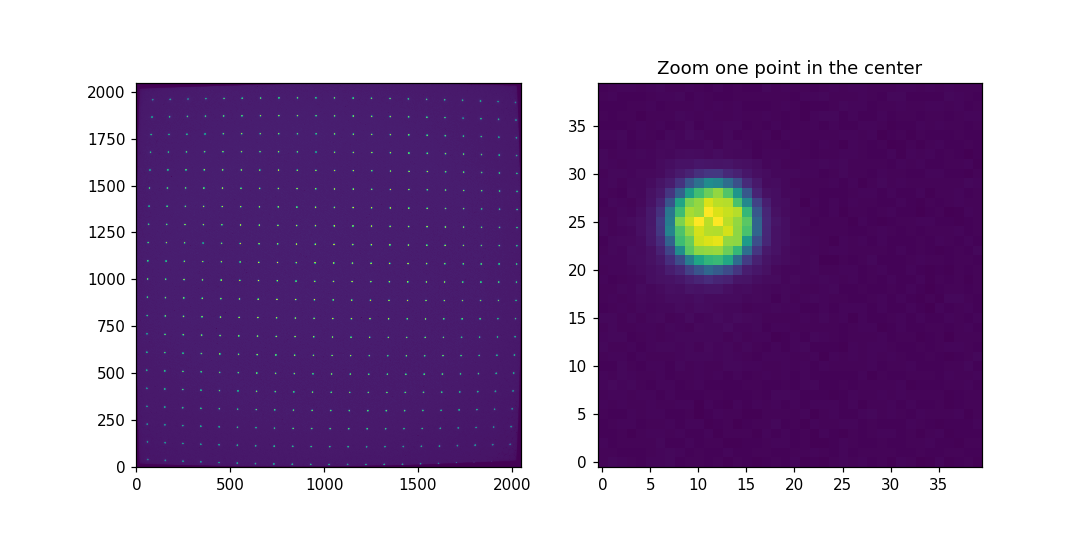

Text(0.5,1,'Zoom one point in the center')

In [3]:
#Display the image, and zoom on one spot
fig,ax = subplots(1, 2, figsize=(10,5))
ax[0].imshow(img, interpolation="nearest", origin="lower")
#Zoom into a spot in the middle of the image, where the distortion is expected to be minimal
ax[1].imshow(img[1060:1100,1040:1080], interpolation="nearest", origin="lower")
ax[1].set_title("Zoom one point in the center")

<IPython.core.display.Javascript object>


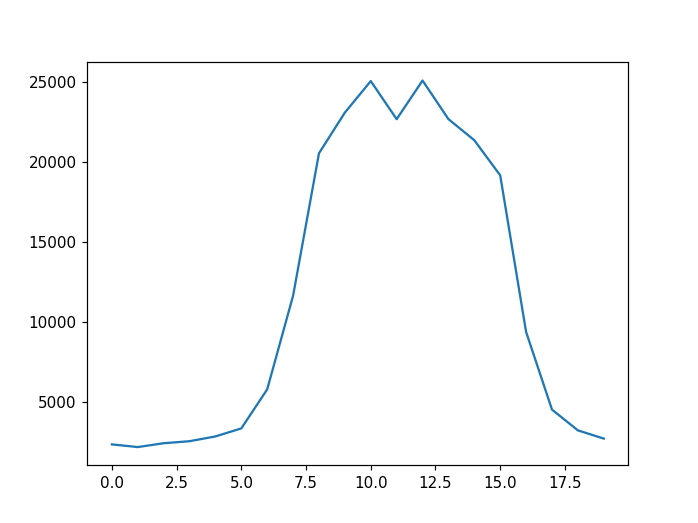

In [4]:
#Look at the profile of the peak to measure the width (it is expected to be a crenel)
fig,ax = subplots()
ax.plot(img[1060+25,1040:1060])

Let's look at one spot, in the center of the image: it is circular and is slightly larger than 10 pixels.
We will define a convolution kernel of size 11x11 of circular shape with sharp borders as this is what a perfect spot is expected to look like. The kernel is normalized in such a way it does not modify the average intensity of the image

Now convolve the image with this circular kernel using scipy.signal (in direct space: the kernel is small and performance does not really matter here). 

It is important to have an odd size for the kernel for convolution as an even shape would induce an offset of 1/2 pixel in the located peak-position.

<IPython.core.display.Javascript object>


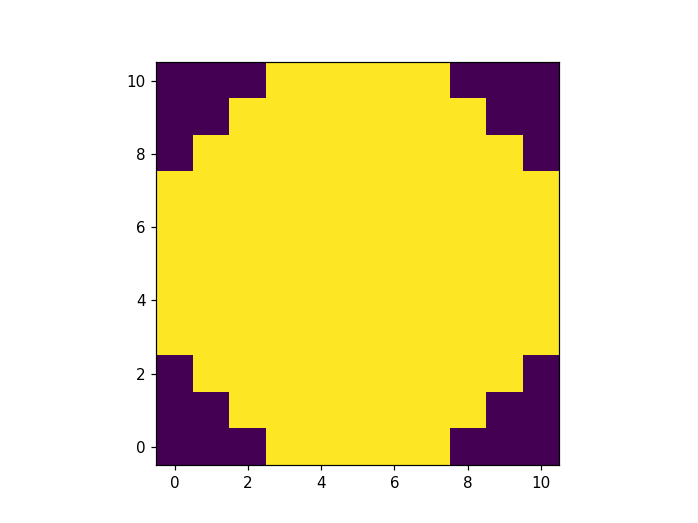

In [5]:
size = 11 #Odd of course
center = (size-1)//2
y, x = numpy.ogrid[-center:center+1,-center:center+1]
r2 = x*x + y*y
kernel = (r2<=(center+0.5)**2).astype(float)
kernel /= kernel.sum()

fig,ax = subplots()
ax.imshow(kernel, interpolation="nearest", origin="lower")

In [6]:
from scipy import ndimage, signal

In [7]:
cnv = signal.convolve2d(img, kernel, mode="same")

In [8]:
#Check that size is unchanged.
print(img.shape) 
print(cnv.shape) 

(2048, 2048)
(2048, 2048)


<IPython.core.display.Javascript object>


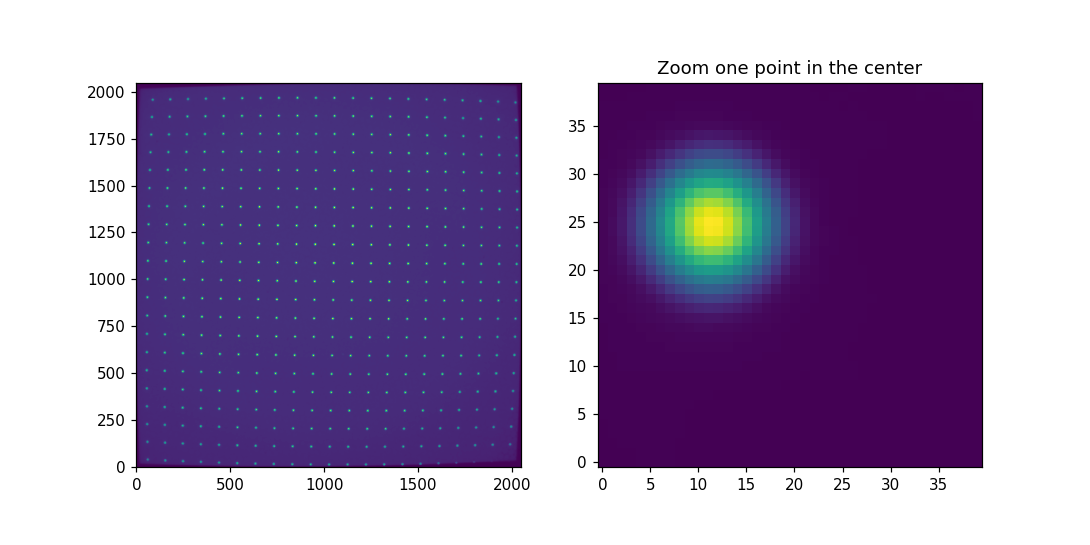

Text(0.5,1,'Zoom one point in the center')

In [9]:
#Check the image still looks the same. it is just supposed to be smoother.

fig,ax = subplots(1,2, figsize=(10,5))
ax[0].imshow(cnv, interpolation="nearest", origin="lower")
#Zoom into a spot in the middle of the image, where the distortion is expected to be minimal
ax[1].imshow(cnv[1060:1100,1040:1080], interpolation="nearest", origin="lower")
ax[1].set_title("Zoom one point in the center")


In [10]:
#Zoom into the very same spot to ensure it is smoother
imshow(cnv[1060:1100,1040:1080], interpolation="nearest", origin="lower")

<IPython.core.display.Javascript object>


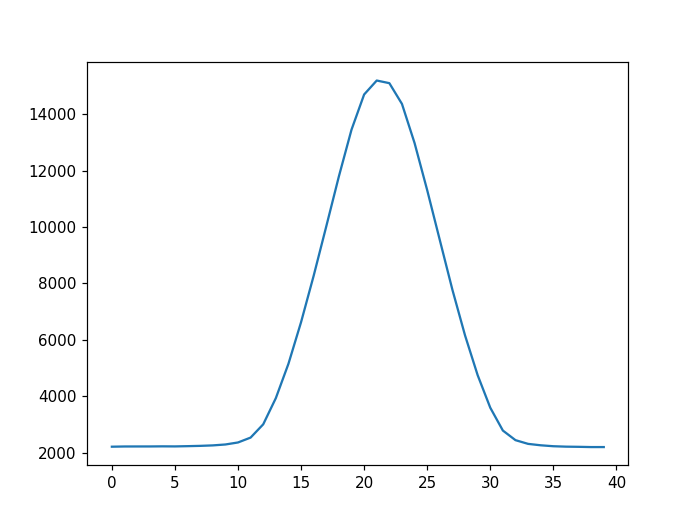

In [11]:
# and here again the same profile:
fig, ax = subplots() 
ax.plot(cnv[1060+25,1030:1070])
# the peak got broader (2x) but much smoother on the top: this is what we are interrested in.

After convolution with a pattern of the same shape as the hole, the peak center is located with a sub-pixel resolution.
The peak has a full size of 30 pixels in 1 dimension.

All peak positions will be extracted using the pyFAI inverse watershed algorithm. 
Once all regions are segmented, the ones too small are sieved out and the remaining ones are classifies according to their peak intensity using an histogram. As intensity vary a lot, this histogram it is done on the log-scale of the intensity.

In [12]:
mini = (kernel>0).sum()
print("Number of points in the kernel: %s"%mini)

Number of points in the kernel: 97


In [13]:
try: #depends if the version of pyFAI you are using
    from pyFAI.watershed import InverseWatershed
except:
    from pyFAI.ext.watershed import InverseWatershed
    #Version of pyFAI newer than feb 2016
iw = InverseWatershed(cnv)
iw.init()
iw.merge_singleton()
all_regions = set(iw.regions.values())
regions = [i for i in all_regions if i.size>mini]

print("Number of region segmented: %s"%len(all_regions))
print("Number of large enough regions : %s"%len(regions))

Number of region segmented: 79513
Number of large enough regions : 8443


<IPython.core.display.Javascript object>


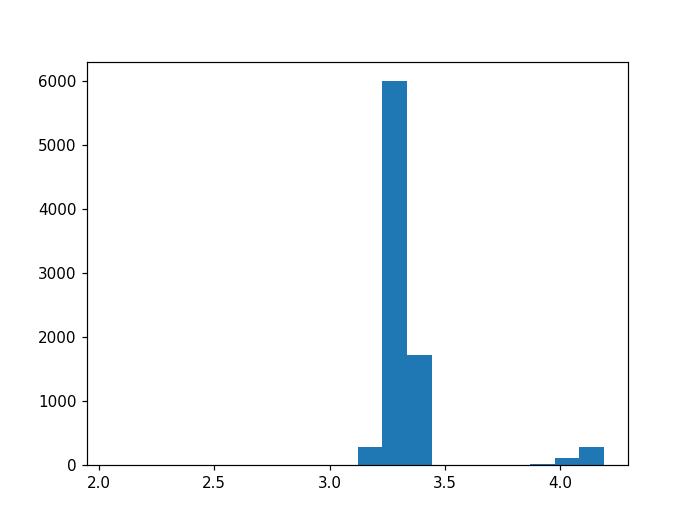

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.850e+02, 5.999e+03,
        1.719e+03, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 2.300e+01,
        1.170e+02, 2.930e+02]),
 array([2.05537045, 2.1621182 , 2.26886594, 2.37561369, 2.48236143,
        2.58910918, 2.69585692, 2.80260467, 2.90935241, 3.01610016,
        3.1228479 , 3.22959565, 3.33634339, 3.44309114, 3.54983888,
        3.65658663, 3.76333437, 3.87008212, 3.97682986, 4.08357761,
        4.19032535]),
 <a list of 20 Patch objects>)

In [14]:
s = [i.maxi for i in regions]

fig, ax = subplots()
ax.hist(numpy.log10(s), 20)
#Look for the maximum value in each region to be able to segment accordingly

There are clearly 3 groups of very different intensity, well segregated:

* around $10^{2.1}$ (~125), those are the peaks where no tapper brings light
* around $10^{3.4}$ (~2500), those are segmented region in the background
* above $10^{3.9}$ (~8000), those are actual peaks, we are looking for.

We retain all peaks >$10^{3.5}$

In [15]:
peaks = [(i.index//img.shape[-1], i.index%img.shape[-1]) for i in regions if (i.maxi)>10**3.5]
print("Number of remaining peaks: %s"%len(peaks))

Number of remaining peaks: 438


<IPython.core.display.Javascript object>


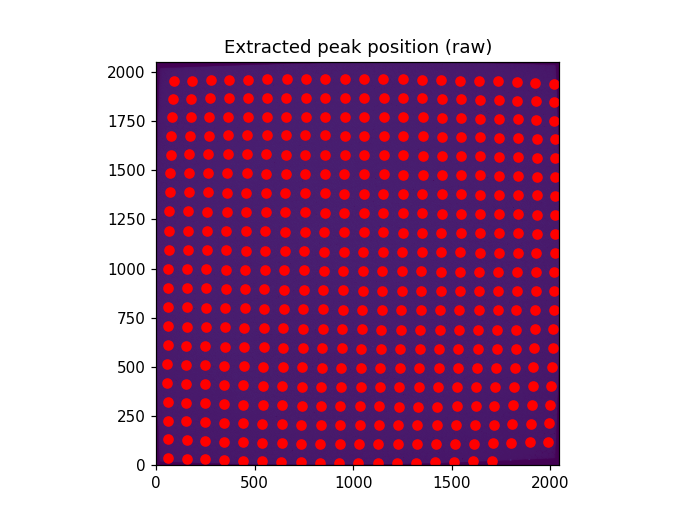

Raw peak coordinate:
[(1866, 369), (1664, 1742), (1866, 1155), (1867, 466), (1867, 563), (1274, 1933), (107, 1226), (1666, 1646), (1867, 1056), (1868, 661)]


In [16]:
fix, ax = subplots()
ax.imshow(img, interpolation="nearest", origin="lower")
peaks_raw = numpy.array(peaks)
plot(peaks_raw[:,1], peaks_raw[:, 0], "or")
xlim(0,2048)
ylim(0,2048)
title("Extracted peak position (raw)")
print("Raw peak coordinate:")
print(peaks[:10])

## Precise peak extraction is performed using a second order tailor expansion

In [17]:
try:
    from pyFAI.bilinear import Bilinear
except:
    from pyFAI.ext.bilinear import Bilinear
bl = Bilinear(cnv)

<IPython.core.display.Javascript object>


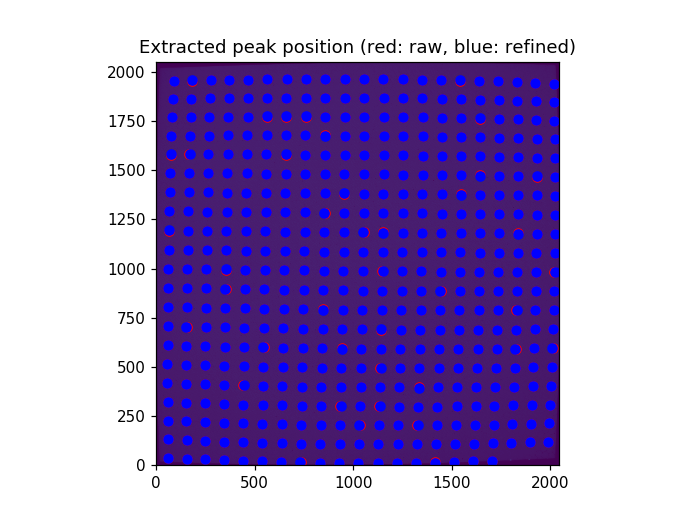

Refined peak coordinate:
[(1865.5498712658882, 369.26084446907043), (1664.0545781441033, 1742.1054049506783), (1866.365830898285, 1154.7454472184181), (1866.5777518451214, 465.5264100730419), (1867.4438569247723, 563.2241970151663), (1274.126026943326, 1932.9975793703925), (106.92814844101667, 1226.3799100518227), (1666.296777099371, 1645.9045108556747), (1867.3492084741592, 1056.0545778758824), (1868.0366475954652, 661.3404867351055)]


In [18]:
ref_peaks = [bl.local_maxi(p) for p in peaks]
fig, ax = subplots()
ax.imshow(img, interpolation="nearest", origin="lower")
peaks_ref = numpy.array(ref_peaks)
ax.plot(peaks_raw[:,1], peaks_raw[:, 0], "or")
ax.plot(peaks_ref[:,1],peaks_ref[:, 0], "ob")
xlim(0,2048)
ylim(0,2048)
title("Extracted peak position (red: raw, blue: refined)")
print("Refined peak coordinate:")
print(ref_peaks[:10])

At this stage, a visual inspection of the grid confirms all peaks have been properly segmented. If this is not the case, one can adapt:

* the size of the kernel
* the threshold coming out of the histogramming

## Pair-wise distribution function

We will now select the (4-) first neighbours for every single peak.
For this we calculate the distance_matrix from any point to any other: 

In [19]:
# Nota, pyFAI uses **C-coordinates** so they come out as (y,x) and not the usual (x,y). 
# This notation helps us to remind the order
yx = numpy.array(ref_peaks)

In [20]:
# pairwise distance calculation using scipy.spatial.distance_matrix
from scipy.spatial import distance_matrix
dist = distance_matrix(peaks_ref, peaks_ref)

Let's have a look at the pairwise distribution function for the first neighbors

<IPython.core.display.Javascript object>


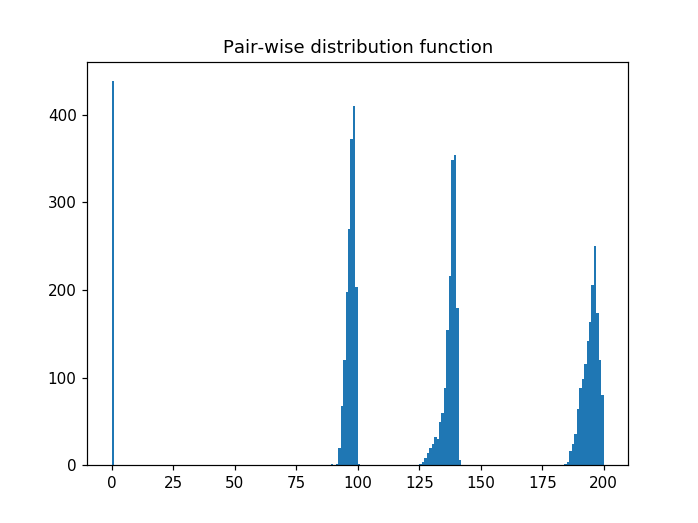

Text(0.5,1,'Pair-wise distribution function')

In [21]:
fig, ax = subplots()
ax.hist(dist.ravel(), 200, range=(0,200))
title("Pair-wise distribution function")

This histogram provides us:

* At 0, the 438 peaks with 0-distance to themselves.
* between 85 and 105 the first neighbours
* between 125 and 150 the second neighbours.
* ... and so on.

We now focus on the first neighbours which are all located between 70 and 110 pixels apart.

In [22]:
#We define here a data-type for each peak (called center) with 4 neighbours (called north, east, south and west). 
point_type = np.dtype([('center_y', float), ('center_x', float),
                        ('east_y', float), ('east_x', float),
                        ('west_y', float), ('west_x', float),
                        ('north_y', float), ('north_x', float),
                        ('south_y', float), ('south_x', float)])

neig = np.logical_and(dist>70.0, dist<110.0)
valid = (neig.sum(axis=-1)==4).sum()
print("There are %i control point with exactly 4 first neigbours"%valid)
# This initializes an empty structure to be populated
point = numpy.zeros(valid, point_type)

There are 359 control point with exactly 4 first neigbours


In [23]:
#Populate the structure: we use a loop as it loops only over 400 points 
h=-1
for i, center in enumerate(peaks_ref):
    if neig[i].sum()!=4: continue
    h+=1
    point[h]["center_y"],point[h]["center_x"] = center
    for j in ((0,1),(0,-1),(1,0),(-1,0)):
        tmp = []
        for k in numpy.where(neig[i]):
            curr = yx[k]
            tmp.append(dot(curr-center,j))
            l = argmax(tmp)
            y, x = peaks_ref[numpy.where(neig[i])][l]
            if j==(0,1):point[h]["east_y"], point[h]["east_x"] = y, x
            elif j==(0,-1):point[h]["west_y"], point[h]["west_x"] = y, x
            elif j==(1,0): point[h]["north_y"],point[h]["north_x"] = y, x
            elif j==(-1,0):point[h]["south_y"],point[h]["south_x"] = y, x

We will need to define an *origin* but taking it on the border of the image is looking for trouble as this is where distortions are likely to be the most important. The center of the detector is an option but we prefer to take the peak the nearest to the centroid of all other peaks.

In [24]:
#Select the initial guess for the center:

#Most intense peak:
#m = max([i for i in regions], key=lambda i:i.maxi)
#Cx, Cy = m.index%img.shape[-1],m.index//img.shape[-1]
#Cx, Cy = point["center_x"].mean(), point["center_y"].mean() #Centroid of all points
Cx, Cy = 734, 1181 #beam center
#Cx, Cy = tuple(i//2 for i in cnv.shape) #detector center
print("The guessed center is at (%s, %s)"%(Cx, Cy))

#Get the nearest point from centroid:
d2 = ((point["center_x"]-Cx)**2+(point["center_y"]-Cy)**2)
best = d2.argmin()
Op = point[best]
Ox, Oy = Op["center_x"], Op["center_y"]

print("The center is at (%s, %s)"%(Ox, Oy))
#Calculate the average vector along the 4 main axes 
Xx = (point[:]["east_x"] - point[:]["center_x"]).mean()
Xy = (point[:]["east_y"] - point[:]["center_y"]).mean()
Yx = (point[:]["north_x"] - point[:]["center_x"]).mean()
Yy = (point[:]["north_y"] - point[:]["center_y"]).mean()

print("The X vector is is at (%s, %s)"%(Xx, Xy))
print("The Y vector is is at (%s, %s)"%(Yx, Yy))

The guessed center is at (734, 1181)
The center is at (753.7035001516342, 1186.1879850327969)
The X vector is is at (97.71973018262348, -0.7879771176533654)
The Y vector is is at (1.382185794965657, 97.08269907579457)


In [25]:
print("X has an angle of %s deg"%rad2deg(arctan2(Xy, Xx)))
print("Y has an angle of %s deg"%rad2deg(arctan2(Yy, Yx)))
print("The XY angle is %s deg"%rad2deg(arctan2(Yy, Yx)-arctan2(Xy, Xx)))

X has an angle of -0.4620027563549718 deg
Y has an angle of 89.18432364179688 deg
The XY angle is 89.64632639815186 deg


In [26]:
x = point[:]["center_x"] - Ox
y = point[:]["center_y"] - Oy
xy = numpy.vstack((x,y))
R = numpy.array([[Xx,Yx],[Xy,Yy]])
iR = numpy.linalg.inv(R)
IJ = dot(iR,xy).T

In [27]:
Xmin = IJ[:,0].min()
Xmax = IJ[:,0].max()
Ymin = IJ[:,1].min()
Ymax = IJ[:,1].max()
print("Xmin/max",Xmin, Xmax)
print("Ymin/max",Ymin,Ymax)
print("Maximum error versus integrer: %s * pitch size (5mm)"%(abs(IJ-IJ.round()).max()))

Xmin/max -6.073942128478845 12.06072105601781
Ymin/max -11.08905457323414 7.040603636712159
Maximum error versus integrer: 0.11721135467538701 * pitch size (5mm)


At this point it is important to check the correct rounding to integers: The maximum error should definitely be better than 0.2*pitch ! If not, try to change the origin (Cx and Cy). This criteria will be used for the optimization later on.

<IPython.core.display.Javascript object>


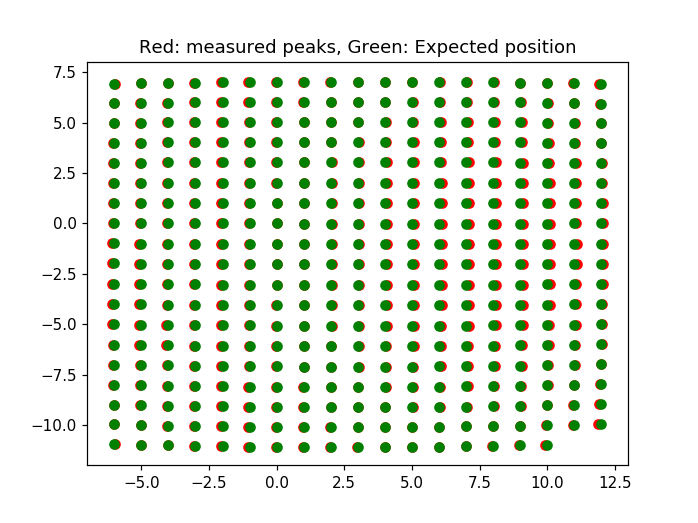

Text(0.5,1,'Red: measured peaks, Green: Expected position')

In [28]:
fig, ax = subplots()
plot(IJ[:,0],IJ[:,1],"or")
idx = numpy.round(IJ).astype(int)
plot(idx[:,0],IJ[:,1],"og")
xlim(floor(Xmin), ceil(Xmax))
ylim(floor(Ymin), ceil(Ymax))
title("Red: measured peaks, Green: Expected position")

### Estimation of the pixel size:

The pixel size is obtained from the pitch of the grid, in vectorial:

$$pitch^2 = (Px \cdot Xx)^2 + (Py \cdot Xy)^2$$

$$pitch^2 = (Px \cdot Yx)^2 + (Py \cdot Yy)^2$$

In [29]:
pitch = 5e-3 #mm distance between holes
Py = pitch*sqrt((Yx**2-Xx**2)/((Xy*Yx)**2-(Xx*Yy)**2))
Px = sqrt((pitch**2-(Xy*Py)**2)/Xx**2)
print("Pixel size in average: x:%.3f micron, y: %.3f microns"%(Px*1e6, Py*1e6))

Pixel size in average: x:51.165 micron, y: 51.497 microns


At this stage, we have:

 * A list of control points placed on a regular grid with a sub-pixel precision
 * The center of the image, located on a control point
 * the average X and Y vector to go from one control point to another



## Optimization of the pixel position


The optimization is obtained by minimizing the mis-placement of the control points on the regular grid. For a larger coverage we include now the peaks on the border with less than 4 neighbours.

In [30]:
#Measured peaks (all!), needs to flip x<->y
peaks_m = numpy.empty_like(peaks_ref)
peaks_m[:,1] = peaks_ref[:,0]
peaks_m[:,0] = peaks_ref[:,1]

#parameter set for optimization:
P0 = [Ox, Oy, Xx, Yx, Xy, Yy]

P = numpy.array(P0)

def to_hole(P, pixels):
    "Translate pixel -> hole"
    T = numpy.atleast_2d(P[:2])
    R = P[2:].reshape((2,2))
    #Transformation matrix from pixel to holes:
    hole = dot(numpy.linalg.inv(R), (pixels - T).T).T
    return hole

def to_pix(P, holes):
    "Translate hole -> pixel"
    T = numpy.atleast_2d(P[:2])
    R = P[2:].reshape((2,2))
    #Transformation from index points (holes) to pixel coordinates: 
    pix = dot(R,holes.T).T + T
    return pix

def error(P):
    "Error function"
    hole_float = to_hole(P, peaks_m)
    hole_int = hole_float.round()
    delta = hole_float-hole_int
    delta2 = (delta**2).sum()
    return delta2

print("Total inital error ", error(P), P0)
holes = to_hole(P, peaks_m)
print("Maximum initial error versus integrer: %s * pitch size (5mm)"%(abs(holes-holes.round()).max()))
from scipy.optimize import minimize
res = minimize(error, P)
print(res)
print("total Final error ", error(res.x),res.x)
holes = to_hole(res.x, peaks_m)
print("Maximum final error versus integrer: %s * pitch size (5mm)"%(abs(holes-holes.round()).max()))

Total inital error  2.5995763607010702 [753.7035001516342, 1186.1879850327969, 97.71973018262348, 1.382185794965657, -0.7879771176533654, 97.08269907579457]
Maximum initial error versus integrer: 0.19983845643285036 * pitch size (5mm)
      fun: 2.1237728421711917
 hess_inv: array([[ 1.43694812e+01,  5.05717379e-01, -8.90320653e-01,
         5.64195763e-01, -1.23930767e-02,  6.02161660e-02],
       [ 5.05717379e-01,  1.43370603e+01, -2.72600087e-02,
         1.44387694e-02, -8.61324331e-01,  5.83758750e-01],
       [-8.90320653e-01, -2.72600087e-02,  3.01138649e-01,
        -4.87432612e-03,  3.09135300e-03, -3.84422410e-03],
       [ 5.64195763e-01,  1.44387694e-02, -4.87432612e-03,
         3.01046798e-01, -3.55586277e-04,  4.10647957e-03],
       [-1.23930767e-02, -8.61324331e-01,  3.09135300e-03,
        -3.55586277e-04,  2.96139435e-01, -4.30940164e-03],
       [ 6.02161660e-02,  5.83758750e-01, -3.84422410e-03,
         4.10647957e-03, -4.30940164e-03,  2.96856924e-01]])
      jac

<IPython.core.display.Javascript object>


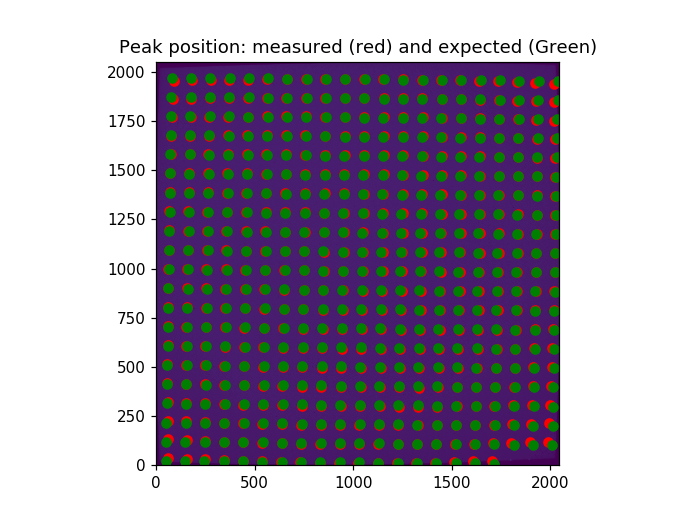

Text(0.5,1,'Peak position: measured (red) and expected (Green)')

In [31]:
fig,ax = subplots()
peaks_c = to_pix(res.x,to_hole(res.x,peaks_m).round())
ax.imshow(img, interpolation="nearest", origin="lower")
ax.plot(peaks_m[:,0],peaks_m[:, 1], "or")
ax.plot(peaks_c[:,0], peaks_c[:, 1], "og")
xlim(0, 2048)
ylim(0, 2048)
ax.set_title("Peak position: measured (red) and expected (Green)")

In [32]:
pitch = 5e-3 #mm distance between holes
Ox, Oy, Xx, Yx, Xy, Yy = res.x
Py = pitch*sqrt((Yx**2-Xx**2)/((Xy*Yx)**2-(Xx*Yy)**2))
Px = sqrt((pitch**2-(Xy*Py)**2)/Xx**2)
print("Optimized pixel size in average: x:%.3f micron, y: %.3f microns"%(Px*1e6, Py*1e6))

Optimized pixel size in average: x:50.959 micron, y: 51.373 microns


Few comments:

* The maximum error grow during optimization without explanations
* The outer part of the detector is the most distorted

## Interpolation of  the fitted data

### Multivariate data interpolation (griddata)


Correction arrays are built slightly larger (+1) to be able to manipulate corners instead of centers of pixels
As coordinates are needed as y,x (and not x,y) we use p instead of peaks_m

<IPython.core.display.Javascript object>


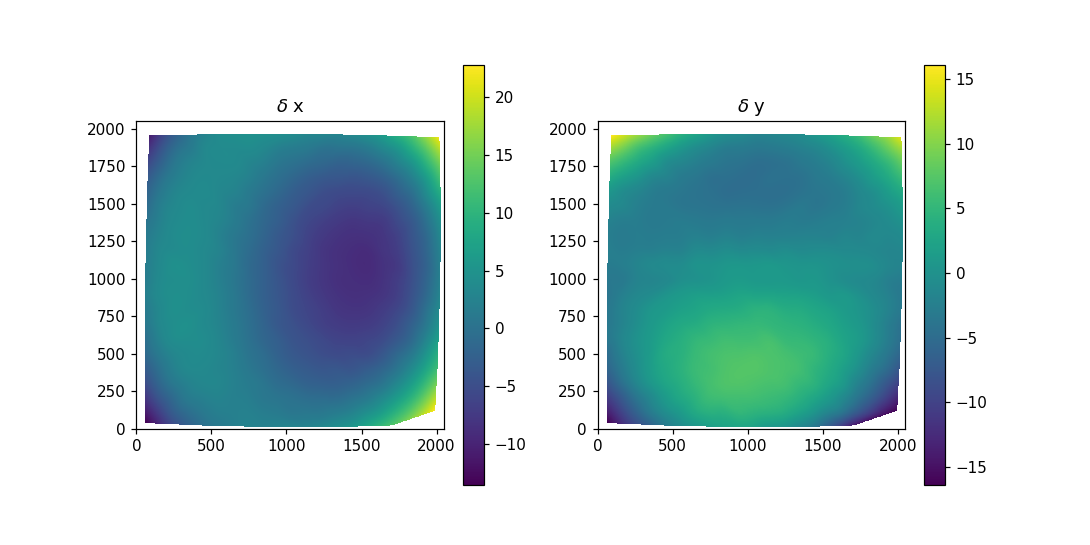

In [33]:
from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[0:img.shape[0]+1, 0:img.shape[1]+1]
delta = peaks_c - peaks_m
#we use peaks_res instead of peaks_m to be in y,x coordinates, not x,y
delta_x = griddata(peaks_ref, delta[:,0], (grid_x, grid_y), method='cubic')
delta_y = griddata(peaks_ref, delta[:,1], (grid_x, grid_y), method='cubic')

fig, ax = subplots(1, 2, figsize=(10,5))
im0 = ax[0].imshow(delta_x,origin="lower", interpolation="nearest")
ax[0].set_title(r"$\delta$ x")
fig.colorbar(im0, ax=ax[0])

im1=ax[1].imshow(delta_y, origin="lower", interpolation="nearest")
ax[1].set_title(r"$\delta$ y")
fig.colorbar(im1, ax=ax[1])

#Nota: the arrays are filled with "NaN" outside the convex Hull

In [34]:
#From http://stackoverflow.com/questions/3662361/fill-in-missing-values-with-nearest-neighbour-in-python-numpy-masked-arrays
def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """

    if invalid is None: 
        invalid = numpy.isnan(data)

    ind = ndimage.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

<IPython.core.display.Javascript object>


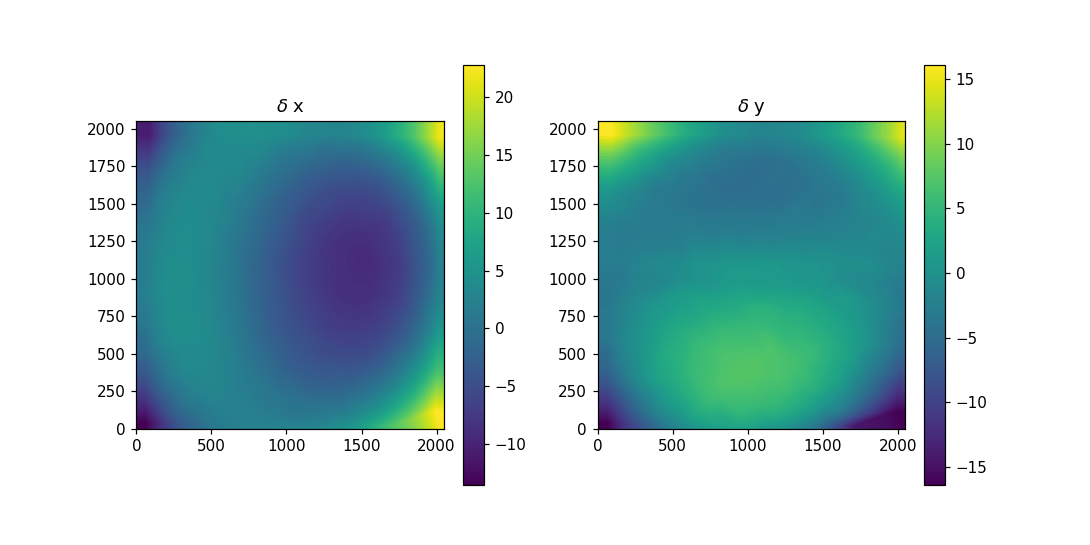

In [35]:
fig, ax = subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(fill(delta_x),origin="lower", interpolation="nearest")
ax[0].set_title(r"$\delta$ x")
fig.colorbar(im0, ax=ax[0])

im1 = imshow(fill(delta_y), origin="lower", interpolation="nearest")
title(r"$\delta$ y")
fig.colorbar(im1, ax=ax[1])

It is important to understand the extrapolation outside the convex hull has no justification, it is there just to prevent numerical bugs.

## Saving the distortion correction arrays to a detector

In [36]:
from pyFAI.detectors import Detector
detector = Detector(Py,Px)
detector.max_shape = detector.shape = img.shape
detector.set_dx(fill(delta_x))
detector.set_dy(fill(delta_y))
detector.mask = numpy.isnan(delta_x).astype(numpy.int8)[:img.shape[0], :img.shape[1]]
detector.save("testdetector.h5")

## Validation of the distortion correction

<IPython.core.display.Javascript object>


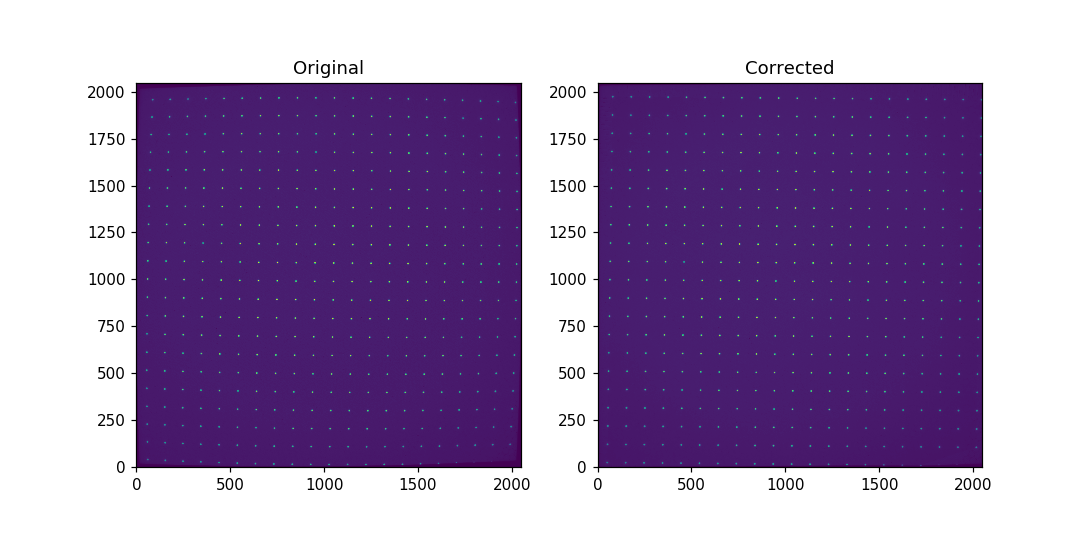

In [37]:
from pyFAI.distortion import Distortion
dis = Distortion(detector)
cor = dis.correct(img)

fig, ax = subplots(1, 2, figsize=(10,5))
ax[0].imshow(img, interpolation="nearest", origin="lower")
ax[0].set_title("Original")

ax[1].imshow(cor, origin="lower", interpolation="nearest")
ax[1].set_title("Corrected")

# Save the corrected image
fabio.edfimage.EdfImage(data=cor).save("corrected.edf")

## Conclusion

This procedure describes how to measure the detector distortion and how to create a detector description file directly usable in pyFAI. Only the region inside the convex hull of the grid data-points is valid and the region of the detector which is not calibrated has been masked out to prevent accidental use of it.

The distortion corrected image can now be used to check how "good" the calibration actually is. This file can be injected in the third cell, and follow the same procedure (left as exercise). This gives a maximum mis-placement of 0.003, the average error is then of 0.0006 and correction-map exhibit a displacement of pixels in the range +/- 0.2 pixels which is acceptable and validates the whole procedure.

In [38]:
print("Execution time: %.3fs"%(time.time()-start_time))

Execution time: 23.465s
